In [5]:
try:
    from core.raft_stereo_fusion import RAFTStereoFusion
except ImportError:
    import os
    os.chdir("/RAFT-Stereo")
    from core.raft_stereo_fusion import RAFTStereoFusion

In [6]:
from train_fusion.dataloader import StereoDataset

import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader


In [7]:
from fusion_args import FusionArgs
args = FusionArgs()
args.hidden_dims = [128, 128, 128]
args.corr_levels = 4
args.corr_radius = 4
args.n_downsample = 3
args.context_norm = "batch"
args.n_gru_layers = 2
args.shared_backbone = True
args.mixed_precision = True
args.corr_implementation = "reg_cuda"
args.slow_fast_gru = False
args.restore_ckpt = "models/raftstereo-realtime.pth"


args.lr = 0.001
args.train_iters = 7
args.valid_iters = 12
args.wdecay = 0.0001
args.num_steps = 100000
args.valid_steps = 1000
args.name = "StereoFusion"
args.batch_size = 4
args.fusion = "AFF"
args.shared_fusion = False
args.freeze_backbone = []

In [8]:
dataset = StereoDataset("/bean/depth", gt_depth=True, flying3d_json=True)
#dataset = StereoDataset("/bean/depth", real_data_json= True,flow3d_driving_json=False, gt_depth=False)

train_size = int(0.95 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset = dataset.partial(0, train_size)
valid_dataset = dataset.partial(train_size, len(dataset))
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
from core.utils.utils import InputPadder

#train_loader = DataLoader(StereoDataset("/bean/depth/08-01-19-37-50", flow3d_driving_json=True, gt_depth=True), batch_size=args.batch_size, shuffle=True, num_workers=4)

In [9]:
model = nn.DataParallel(RAFTStereoFusion(args)).cuda()

model.load_state_dict(torch.load(args.restore_ckpt), strict=False)
model.train()

DataParallel(
  (module): RAFTStereoFusion(
    (cnet): FusionMultiBasicEncoder(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
    

In [ ]:
from tqdm.notebook import tqdm
from train_fusion.train import train, self_supervised_real_batch, flow_gt_batch
from train_fusion.loss_function import self_supervised_loss, self_fm_loss, gt_loss

train(
    args = args, 
    model = model, 
    train_loader = train_loader, 
    valid_loader = valid_loader, 
    tqdm = tqdm, 
    batch_loader_function=flow_gt_batch, 
    loss_function = gt_loss
)

In [ ]:
from visualize.batch_input_visualize import batch_input_visualize

iterator = iter(valid_loader)
batch_input_visualize(next(iterator))

/home/jinnyeong/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([4, 3, 540, 960]) torch.Size([4, 1, 540, 960])
-2.020369 96.14795 24.268867
-0.31965274 156.14531 24.69416
-3.211555 95.24739 24.735916
1.1439383 172.5599 29.719566


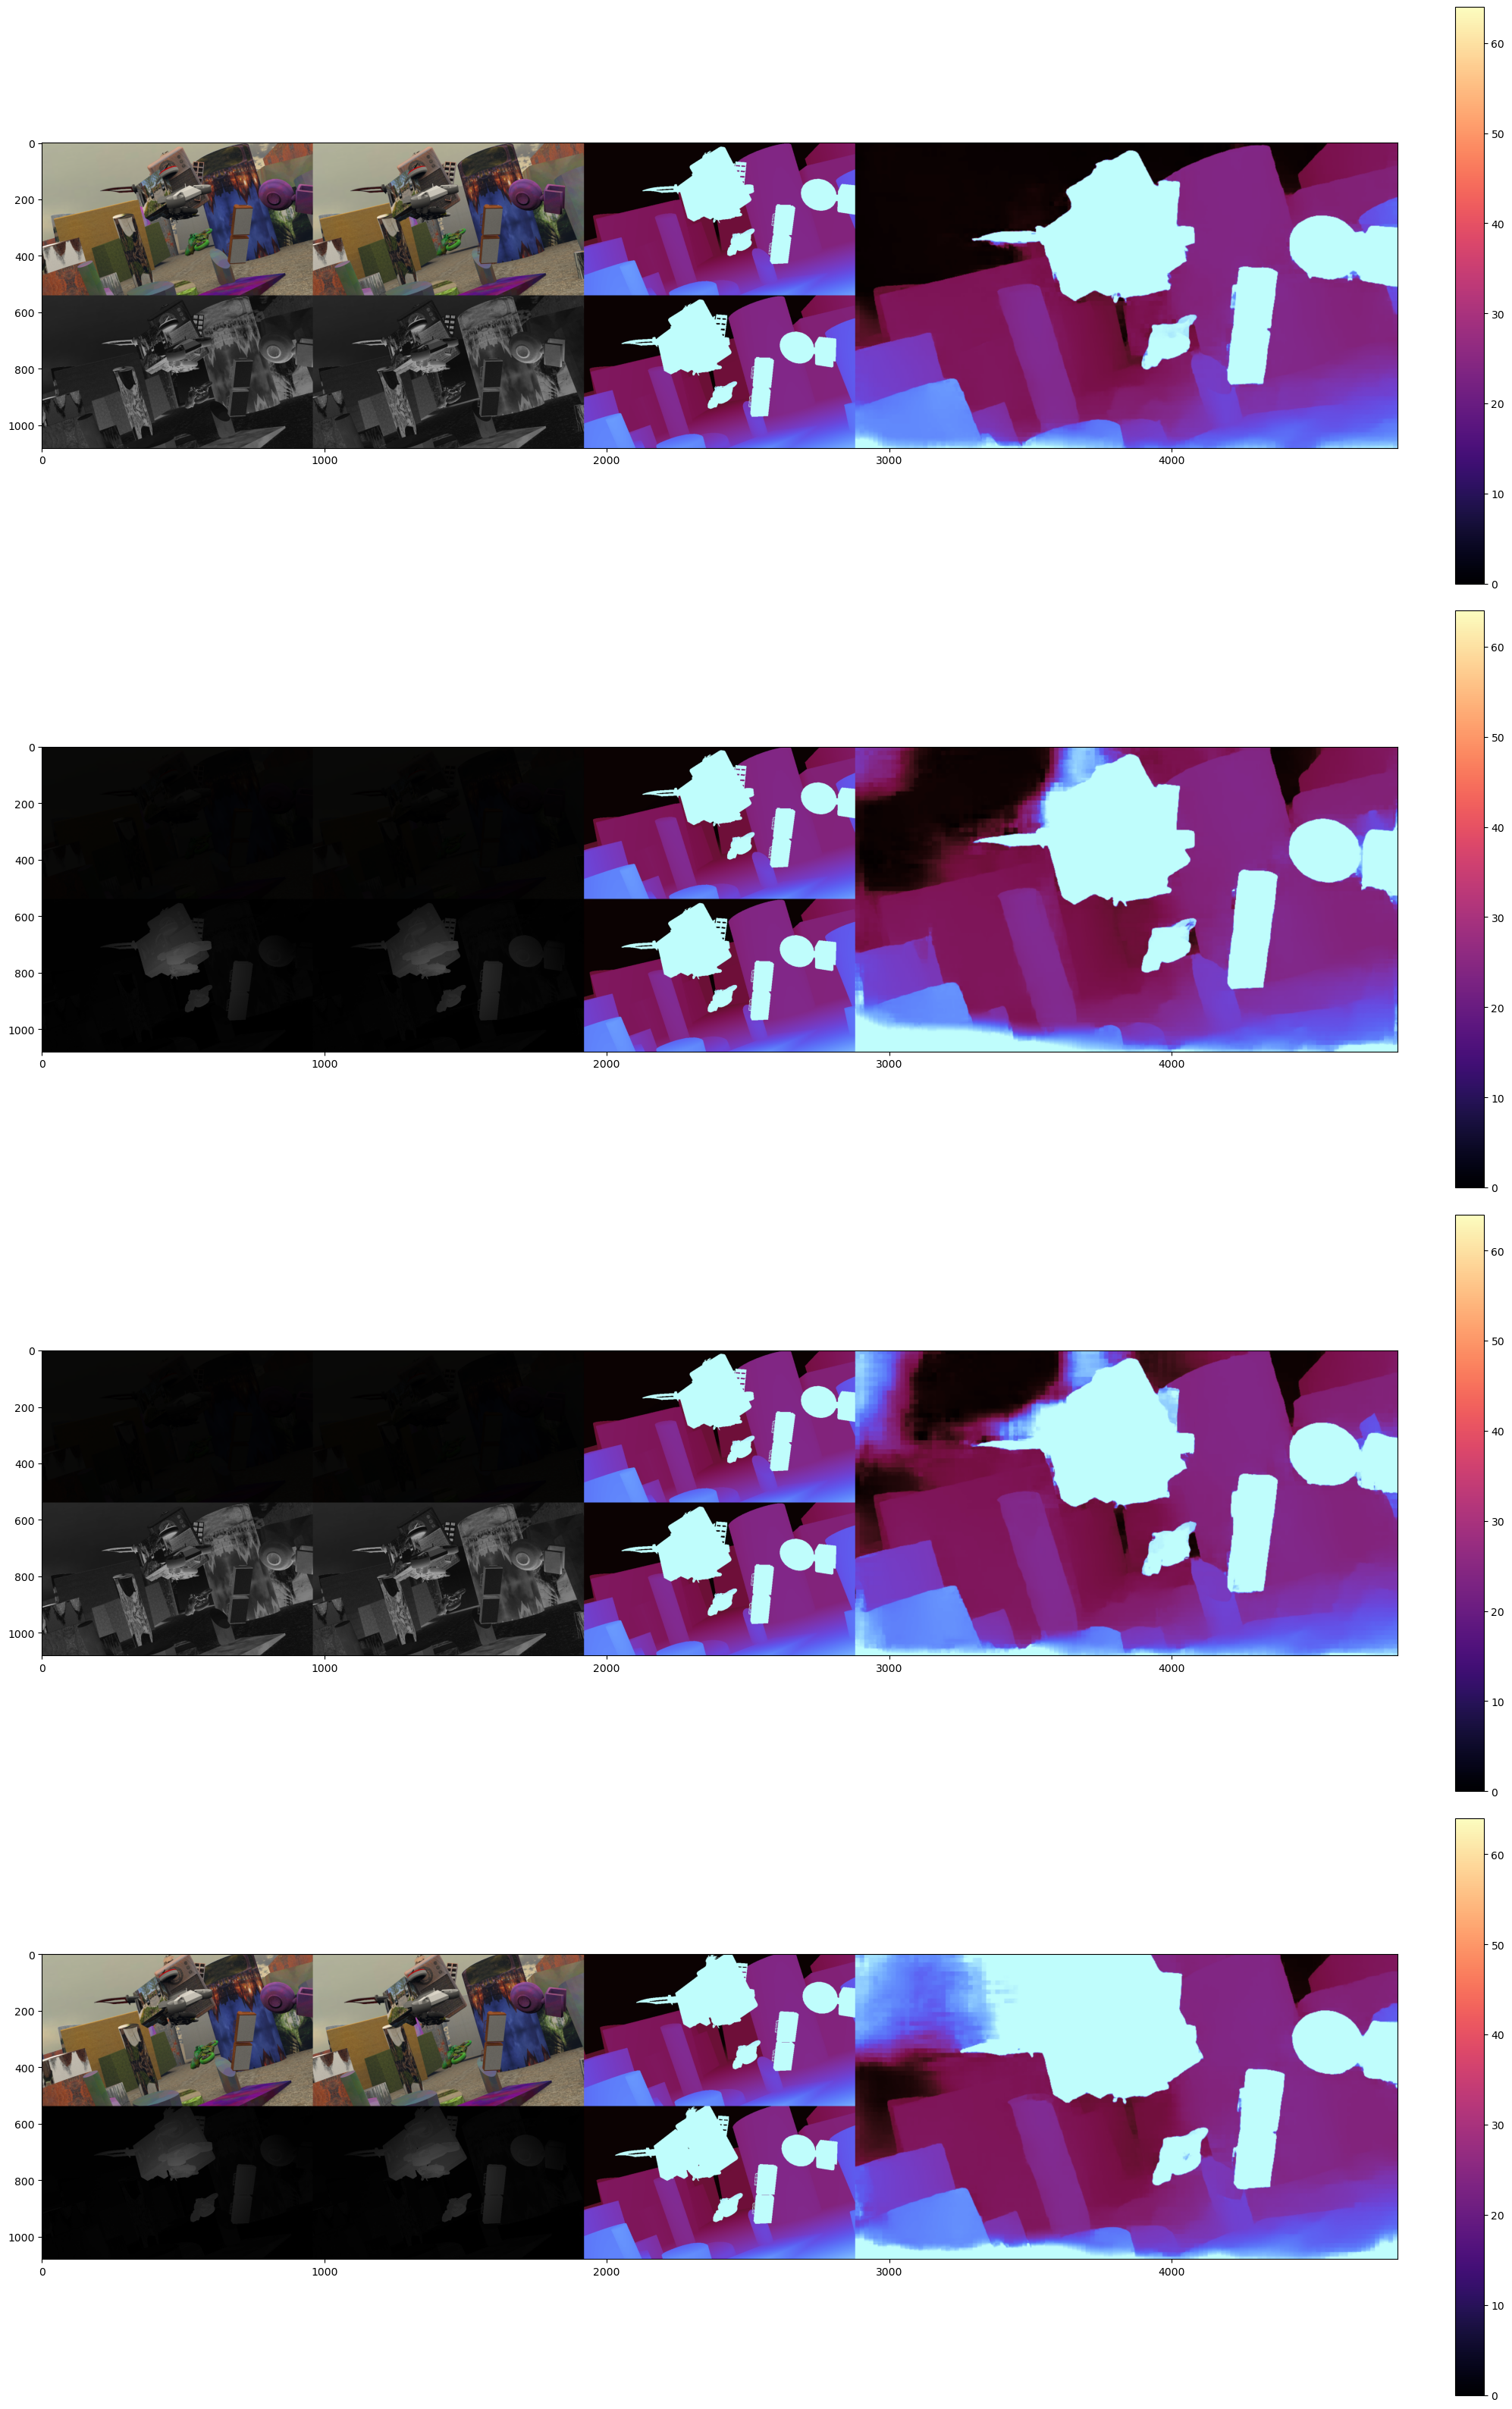

In [11]:
from datastructure.train_input import TrainInput
from visualize.batch_input_visualize import batch_input_visualize
from core.utils.utils import InputPadder
import cv2
from train_fusion.loss_function import warp_reproject_loss, reproject_disparity
iterator = iter(valid_loader)
inputs = next(iterator)
image0, image1, image2, image3, dis1, dis2 = [x.cuda() for x in inputs[1:]]
with torch.no_grad():
    _, flow = model(TrainInput(
            {
                "image_viz_left": image0,
                "image_viz_right": image1,
                "image_nir_left": image2,
                "image_nir_right": image3,
                "iters": args.train_iters,
                "test_mode": True,
                "flow_init": None,
                "heuristic_nir": False,
            }
        ))
print(inputs[1].shape, flow.shape)
batch_input_visualize(inputs, flow)
